In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import resize
import imageio
import glob
import os
import cv2

# Loading Data and creating Dataset

In [25]:
t1_files = [f for f in glob.glob('Tr1/' + '*/*.png', recursive=True)]
t2_files = [f for f in glob.glob('Tr2/' + '*/*.png', recursive=True)]

In [26]:
imgT1 = [np.array(Image.open(t1)) for t1 in t1_files]
imgT2 = [np.array(Image.open(t2)) for t2 in t2_files]

In [27]:
type(imgT1[0])

numpy.ndarray

In [28]:
print("Shape of type1 MRI",imgT1[0].shape)
print("Shape of type2 MRI",imgT2[0].shape)

Shape of type1 MRI (217, 181)
Shape of type2 MRI (217, 181)


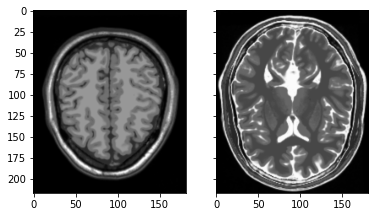

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(imgT1[0], cmap='gray')
ax2.imshow(imgT2[0], cmap='gray')

In [30]:
BATCH_SIZE = 4096

In [31]:
print(imgT1[0])

[[1 1 1 ... 1 2 1]
 [2 2 2 ... 2 2 2]
 [1 2 2 ... 2 2 1]
 ...
 [1 1 0 ... 0 0 1]
 [1 1 0 ... 0 0 1]
 [1 1 0 ... 0 0 0]]


In [32]:
imgT1 = np.stack(imgT1, axis = 0)
imgT1.shape

(43, 217, 181)

In [33]:
imgT2 = np.stack(imgT2, axis = 0)
imgT2.shape

(46, 217, 181)

#### Normalizing images and making pixel values ranging betwwen [-1.0, 1.0]

In [34]:
imgT1 = imgT1/127.5 - 1
imgT2 = imgT2/127.5 - 1

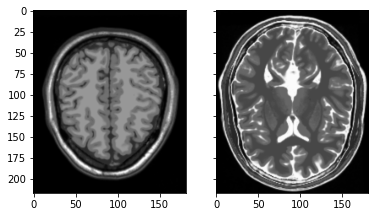

In [35]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(imgT1[0], cmap='gray')
ax2.imshow(imgT2[0], cmap='gray')

# Data Processing
- Resizing Image
- Reshaping Images
- Creating Dataset

In [36]:
typet1_data = np.zeros((imgT1.shape[0], 256, 256, 1))
for index, img in enumerate(imgT1):
    typet1_data[index, :, :, :] = resize(img, (256, 256, 1))
typet1_data.shape

(43, 256, 256, 1)

In [37]:
typet2_data = np.zeros((imgT2.shape[0], 256, 256, 1))
for index, img in enumerate(imgT2):
    typet2_data[index, :, :, :] = resize(img, (256, 256, 1))
typet2_data.shape

(46, 256, 256, 1)

In [38]:
typet1_data = typet1_data.reshape(typet1_data.shape[0], 256, 256, 1).astype('float32')
typet2_data = typet2_data.reshape(typet2_data.shape[0], 256, 256, 1).astype('float32')

In [39]:
typet1_data = tf.data.Dataset.from_tensor_slices(typet1_data).shuffle(imgT1.shape[0], seed=100).batch(BATCH_SIZE)
typet2_data = tf.data.Dataset.from_tensor_slices(typet2_data).shuffle(imgT2.shape[0], seed=100).batch(BATCH_SIZE)

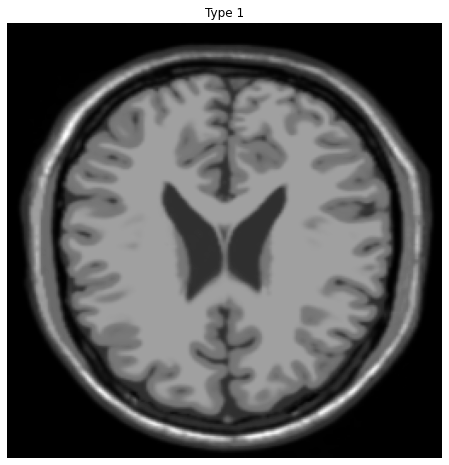

In [40]:
sample_typet1 = next(iter(typet1_data))
plt.figure(figsize=(8, 8))
plt.imshow(sample_typet1[0].numpy()[:, :, 0], cmap='gray')
plt.title('Type 1')
plt.axis('off')
plt.show()

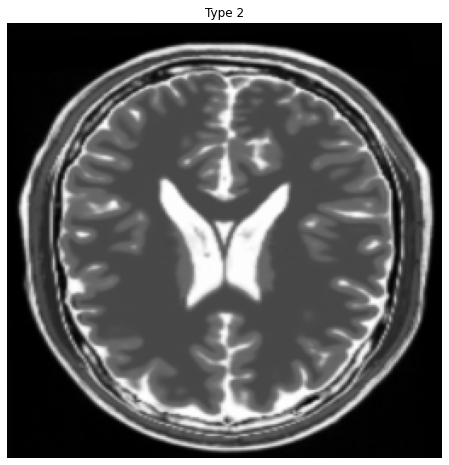

In [41]:
sample_typet2 = next(iter(typet2_data))
plt.figure(figsize=(8, 8))
plt.imshow(sample_typet2[0].numpy()[:, :, 0], cmap='gray')
plt.title('Type 2')
plt.axis('off')
plt.show()

# Model Building

create instance normalization class

In [42]:
class InstanceNormalization(tf.keras.layers.Layer):
    # Initialization of Objects
    def __init__(self, epsilon=1e-5):
        # calling parent's init
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    
    def call(self, x):
        # Compute Mean and Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

### Downsampling

In [43]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    down_layers = tf.keras.Sequential()
    #adding Conv2D layer
    down_layers.add(tf.keras.layers.Conv2D(filters, size, strides = 2, padding = 'same',
                                        kernel_initializer = initializer, use_bias = False))
    #adding normalization
    if apply_norm:
        down_layers.add(InstanceNormalization())
    #adding activation function as Leaky Relu
    down_layers.add(tf.keras.layers.LeakyReLU())
    return down_layers

### Upsampling

In [44]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    up_layers = tf.keras.Sequential()
    # Add Transposed Conv2d layer
    up_layers.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    # Add Normalization Layer
    up_layers.add(InstanceNormalization())
    # Conditionally add Dropout layer
    if apply_dropout:
        up_layers.add(tf.keras.layers.Dropout(0.5))
    # Add Relu Activation Layer
    up_layers.add(tf.keras.layers.ReLU())
    return up_layers

### Creating Unet Architecture

In [45]:
def unet_generator():
    down_stack = [
        downsample(64, 4, False), #(bs, 128, 128, 64)
        downsample(128, 4), #(bs, 64, 64, 128)
        downsample(256, 4), #(bs, 32, 32, 256)
        downsample(512, 4), #(bs, 16, 16, 512)
        downsample(512, 4), #(bs, 8, 8, 512)
        downsample(512, 4), #(bs, 4, 4, 512)
        downsample(512, 4), #(bs, 2, 2, 512)
        downsample(512, 4) #(bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (bs, 256, 256, 1)
    inputs = tf.keras.layers.Input(shape=[256, 256, 1])
    concat = tf.keras.layers.Concatenate()
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

## Generator

In [46]:
generator_g = unet_generator()
generator_f = unet_generator()

In [47]:
generator_g.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_30 (Sequential)     (None, 128, 128, 64  1024        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_31 (Sequential)     (None, 64, 64, 128)  131328      ['sequential_30[0][0]']          
                                                                                            

## Discriminator